# Data scraping, preparation, exploration, and pre-processing

## Data scraping

We scrape article metadata using the New York Times API. For our project we will analyze articles published between May 15th, 2023 and May 14th, 2024. We start by importing a few libraries and setting up the API.  
> **Note:** In order to run the following code you will need to create an account on (https://developer.nytimes.com) and obtain your own API key. You will then need to create a file `keys.py` in your local repo directory, and save your API key as a string under the variable name `NYT_API_KEY`.  

In [1]:
import pandas as pd
from pynytimes import NYTAPI
from datetime import datetime
from keys import NYT_API_KEY

if NYT_API_KEY is not None:
    nyt_api = NYTAPI(NYT_API_KEY, parse_dates=True)

data_loc = 'data/nyt_metadata.csv'


We then fetch the data one month at a time and store in a new `.csv` file. Note that the API has a limit of 5 calls per minute (see the API [FAQ's](https://developer.nytimes.com/faq#a11)), so we need to make sure to wait until 12 seconds between consecutive calls. Note that there is also a limit of 500 calls a day.  
We wrap the process in a function so we can easily adjust the start and end date or change the path of the destination file. The function will also check whether the file already exists, and in that case give a warning before executing the procedure. This will help control the risk of restarting the relatively time-consuming process and limit unnecessary calls to the NYT servers.  
Since we are only interested in articles, we also filter out all other document types during the process.  

In [2]:
from os import listdir
from dateutil.rrule import rrule, MONTHLY
from time import sleep

def scrape(start_date: datetime, end_date: datetime, dest: str=data_loc) -> None:
    if NYT_API_KEY is not None:
        # Avoid restarting the process if the .csv already exists...
        execute = dest.split('/')[-1] not in listdir(''.join(dest.split('/')[:-1]))
        # ...unless the user confirms otherwise.
        if not execute:
            execute = input(f'A file already exists at `{dest}`. Do you want to continue?').lower() in ['y', 'yes']

        if execute:
            df = pd.DataFrame()
            for month in rrule(MONTHLY, dtstart=start_date, until=end_date):
                print(f'Working on the month of {month}')
                monthly_df = pd.DataFrame(nyt_api.archive_metadata(date=month))
                monthly_df = monthly_df.loc[monthly_df.pub_date.apply(lambda x: str(x)) >= str(start_date)]
                monthly_df = monthly_df.loc[monthly_df.pub_date.apply(lambda x: str(x)) < str(end_date)]
                monthly_df = monthly_df.loc[monthly_df.document_type=='article']
                if not monthly_df.empty:
                    df = pd.concat([df, monthly_df]) if not df.empty else monthly_df
                sleep(12)   # The NYT servers have a limit of 5 calls per minute.

            df.to_csv(dest)
    
        else:
            print('The file already exists. Scraping cancelled by the user.')
    else:
        print('This did not run because you do not have the API key.')

In [3]:
scrape(datetime(2023, 5, 15), datetime(2024, 5, 15))

The file already exists. Scraping cancelled by the user.


## Exploration

Let us start by reading the dataframe created above and taking a look at general information. Some of the fields have the string `' '` as value, which pandas does not recognised as null by dafault.

In [4]:
df = pd.read_csv(data_loc, na_values=[' '])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42625 entries, 0 to 42624
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        42625 non-null  int64  
 1   abstract          42623 non-null  object 
 2   web_url           42625 non-null  object 
 3   snippet           42462 non-null  object 
 4   lead_paragraph    42479 non-null  object 
 5   print_section     25732 non-null  object 
 6   print_page        25732 non-null  float64
 7   source            42625 non-null  object 
 8   multimedia        42625 non-null  object 
 9   headline          42625 non-null  object 
 10  keywords          42625 non-null  object 
 11  pub_date          42625 non-null  object 
 12  document_type     42625 non-null  object 
 13  news_desk         42624 non-null  object 
 14  section_name      42619 non-null  object 
 15  subsection_name   16890 non-null  object 
 16  byline            42625 non-null  object

We are interested in the columns `'abstract'`, `'snippet'`, and `'lead_paragraph'`. We see above that these columns contain null values, so let us check exactly how many.

In [5]:
columns = ['abstract', 'snippet', 'lead_paragraph']

for column in columns:
    print(df.loc[df[column].isnull()].shape[0])

2
163
146


We can see that the number of rows with null values for the columns of interest is well under 400, i.e. 1% of the total data set, so we may as well ignore those columns.

In [6]:
df = df.dropna(subset=columns)

Now let us take a look at a few rows from the data frame, focusing on the three columns we care about.

In [7]:
df[columns].head()

,abstract,snippet,lead_paragraph
0,"Economic hardship, climate change, political i...","Economic hardship, climate change, political i...",Relative quiet has prevailed along the souther...
1,It’s election night in America. Stay away from...,It’s election night in America. Stay away from...,"The day before Logan Roy died, he delivered a ..."
2,"Tom is stressed in dress shoes, Shiv hides ben...","Tom is stressed in dress shoes, Shiv hides ben...",This article contains spoilers for Episode 8 o...
3,"No corrections appeared in print on Monday, Ma...","No corrections appeared in print on Monday, Ma...",Errors are corrected during the press run when...
4,"Quotation of the Day for Monday, May 15, 2023.","Quotation of the Day for Monday, May 15, 2023.","“For me, it was time to give back the love the..."


There appears to be a strong overlapping between `'abstract'` and `'snippet'`. Let us check how often they actually coincide.

In [8]:
pd.set_option('display.max_colwidth', None)
df.loc[df.abstract != df.snippet][['abstract', 'snippet']]

,abstract,snippet
793,"Over 40 years, Dr. John R. Williams nurtured thousands of acorns, including some from Sherwood Forest and George Washington’s estate, into towering oak trees. His obsession had a singular goal: Transform the grounds of this year’s P.G.A. Championship.","Over 40 years, Dr. John R. Williams nurtured thousands of acorns, including some from Sherwood Forest and George Washington’s estate, into towering oak trees. His obsession had a singular goal: Transform the grounds of this year’s P.G.A. Champions..."
854,"A fire last week at a mosque in St. Paul, Minn., was at least the fifth such act of vandalism against Muslim houses of worship in the state so far this year, officials said. The suspect in the latest fire said he was Muslim and was protesting homelessness.","A fire last week at a mosque in St. Paul, Minn., was at least the fifth such act of vandalism against Muslim houses of worship in the state so far this year, officials said. The suspect in the latest fire said he was Muslim and was protesting home..."
3030,The indictment said the former president had illegally kept documents concerning “United States nuclear programs; potential vulnerabilities of the United States and its allies to military attack; and plans for possible retaliation in response to a foreign attack.”,The indictment said the former president had illegally kept documents concerning “United States nuclear programs; potential vulnerabilities of the United States and its allies to military attack; and plans for possible retaliation in response to a...
3712,"The former Treasury secretary, whose new book is “The Yellow Pad,” says that Ken Auletta’s “The Underclass” convinced him that “trying to break the cycle of poverty through policy and through private efforts is not just right for moral reasons, but is enormously in the interest of all.”","The former Treasury secretary, whose new book is “The Yellow Pad,” says that Ken Auletta’s “The Underclass” convinced him that “trying to break the cycle of poverty through policy and through private efforts is not just right for moral reasons, bu..."
5236,"Larry L. Householder, the former speaker of the Ohio House of Representatives, was sentenced on Thursday after being convicted in March of participating in a racketeering conspiracy that resulted in a bailout for two struggling nuclear power plants.","Larry L. Householder, the former speaker of the Ohio House of Representatives, was sentenced on Thursday after being convicted in March of participating in a racketeering conspiracy that resulted in a bailout for two struggling nuclear power plant..."
5403,"Even as civil rights groups suggest travelers should rethink trips to the state because of policies enacted by its Republican lawmakers, it remains a tourism juggernaut. And some visitors say their spending actually supports opposition to the new laws.","Even as civil rights groups suggest travelers should rethink trips to the state because of policies enacted by its Republican lawmakers, it remains a tourism juggernaut. And some visitors say their spending actually supports opposition to the new ..."
8348,"“My thinking is that reading will focus my mind, bring a hush over the chaos of the day so I can drift off,” says the author of the memoir “Educated,” one of the Book Review’s 10 Best Books of 2018. “But from time to time a book takes hold in that peculiar way that a book can, and I end up reading through the night. ... Books are both the best and worst thing for my sleep.”","“My thinking is that reading will focus my mind, bring a hush over the chaos of the day so I can drift off,” says the author of the memoir “Educated,” one of the Book Review’s 10 Best Books of 2018. “But from time to time a book takes hold in that..."
8699,"An explosion at a political rally on Sunday in northwest Pakistan killed dozens of people and injured 200 more, officials said, the latest sign of the deteriorating security situation in Pakistan, where some militant gro

Well that was disappointing. It appears the difference is not really significant, so we should discard one of the two columns. We will keep the column that had more non-null values in the original data frame, which is `'abstract'`. Before we start over and include the rows that we had previously dropped, let us check whether `'lead_paragraph'` has the same issue.

In [9]:
df.loc[df.abstract == df.lead_paragraph].shape[0]

15

So `'abstract'` and `'lead_paragraph'` are the same for 15 data points. We can probably ignore this, but let us still take a look at what those values are, just in case these are really null values that we did not expect.

In [10]:
df.loc[df.abstract == df.lead_paragraph][['abstract', 'lead_paragraph']]

,abstract,lead_paragraph
2025,There are a lot of unsettling signals coming from the world’s oceans right now.,There are a lot of unsettling signals coming from the world’s oceans right now.
8807,"In theory, there is no branch in the American constitutional system that exists above or beyond the reach of the others.","In theory, there is no branch in the American constitutional system that exists above or beyond the reach of the others."
16586,We bring the movies to you.,We bring the movies to you.
20825,What happens when you realize the people in charge don’t have the answers.,What happens when you realize the people in charge don’t have the answers.
21647,"Things our dads taught us, whether they intended to or not.","Things our dads taught us, whether they intended to or not."
22911,Want to see new art in New York this weekend? Check out a trove of South African art on the Upper East Side and Ed Atkins’s avatars in Chelsea. And don’t miss Kayode Ojo’s sleek sculptures in TriBeCa.,Want to see new art in New York this weekend? Check out a trove of South African art on the Upper East Side and Ed Atkins’s avatars in Chelsea. And don’t miss Kayode Ojo’s sleek sculptures in TriBeCa.
25565,A major political party in a major swing state bets on a new leader: a total political outsider. How does that work out?,A major political party in a major swing state bets on a new leader: a total political outsider. How does that work out?
26560,"This week, Jillian Steinhauer covers Dara Birnbaum’s video art, an intergenerational group show of Atlanta-based artists and Nickola Pottinger’s painted pulp sculptures.","This week, Jillian Steinhauer covers Dara Birnbaum’s video art, an intergenerational group show of Atlanta-based artists and Nickola Pottinger’s painted pulp sculptures."
26748,"There’s the thing you plan to do, and then there’s the thing you end up doing.","There’s the thing you plan to do, and then there’s the thing you end up doing."
30104,What we ask to find out what we really want to know.,What we ask to find out what we really want to know.


These are all valid entries, so we might as well just keep them.  
Let us start over then, and take a look at a larger set of values.

In [11]:
df = pd.read_csv(data_loc, na_values=[' '])

columns = ['abstract', 'lead_paragraph']
df = df.dropna(subset=columns)

df[columns].head(20)

,abstract,lead_paragraph
0,"Economic hardship, climate change, political instability and gang violence will continue to spur emigration from many corners of the world.","Relative quiet has prevailed along the southern U.S. border since Friday, despite widespread fears that ending a pandemic-era policy to immediately expel most migrants, even asylum seekers, would set off a stampede from Mexico."
1,It’s election night in America. Stay away from the bodega sushi.,"The day before Logan Roy died, he delivered a fiery call to arms to his ATN staff, letting them know what he expected from the network going forward. The speech was an angrier variation of the populist spiel he had given many times before, in which he insisted that the news should always be frank and unpretentious. He wanted his anchors to tell their viewers “truthful” things they had never heard anyone say before on television. He wanted ATN to be, in a word, “spicy.”"
2,"Tom is stressed in dress shoes, Shiv hides beneath layers (of lies and a turtleneck), and Willa cosplays as a first lady hopeful.",This article contains spoilers for Episode 8 of the final season of “Succession.”
3,"No corrections appeared in print on Monday, May 15, 2023.","Errors are corrected during the press run whenever possible, so some errors noted here may not have appeared in all editions."
4,"Quotation of the Day for Monday, May 15, 2023.","“For me, it was time to give back the love they gave me before.”"
5,"The 19-year-old French basketball star is the most hyped N.B.A. prospect since LeBron James, but he says he isn’t fazed by the pressure.",Boris Diaw was passing through Paris in late September and thought he would check out a basketball game. A young player he had heard about for years was playing.
6,"New York City students are struggling with reading, but principals are worried that the rollout of a new teaching method is happening too quickly.",Good morning. It’s Monday. We’ll look at something so fundamental it’s the first of the three R’s — and why New York City is about to change the way it is taught in public schools.
7,Results of Turkey’s election.,"Turkey’s presidential election appears to be destined for a runoff after the incumbent, Recep Tayyip Erdogan, failed to win a majority of the vote, in the toughest political challenge of his career."
8,Shouldn’t a protest movement led by unions be benefiting the left?,"For three months, France has been in revolt: Demonstrators have marched; railroad workers have blocked tracks; barricades and buildings have been set aflame; protesters have done battle in the street with police. The most recent innovation has been tamer: People have banged pots whenever the president has appeared. The cause? President Emmanuel Macron’s measure raising the retirement age from 62 to 64."
9,"A spy drama based on a decades-long manhunt comes to Showtime, and a new FX documentary brings back former Hillsong pastors to reflect on the church’s scandal.","Between network, cable and streaming, the modern television landscape is a vast one. Here are some of the shows, specials and movies coming to TV this week, May 15-21. Details and times are subject to change."


### Some data cleaning and word count

Now that we have selected which columns to work with and cleared out all invalid entries, we should take a closer look at the word count in each piece of text. Before we proceed to that, it might be a good time to do some cleaning, such as bringing all text to lower case and removing irrelevant characters. This can be achieved as part of the "tokenization" process, i.e. splitting of the text into words. We do this by means of an appropriate class from the `nltk` library. We start by importing tha library and instantiating the class.

In [12]:
from nltk.tokenize import RegexpTokenizer

The `RegexpTokenizer` class is instantiated by passing it a regular expression, and its `tokenize` method will take a string as argument and return the list of substrings matching the given regular expression.

#### Special characters

Special characters can give rise to a few problems. First, some characters can appear in different "versions", including for instance spaces and their unbreakable version, quotes (`'` and `’`, and similarly for the double quotes), an more. Additionally, accented characters (such as `à`, `ÿ`, `ø`, `ñ`) make it trickier to use regular expressions. Ineed, the simplest way to detect words using regular expressions is to use the metacharacter `\w` matching all alphanumeric characters, so in particular the expression `\w{2,}` would match any sequence of two or more such characters. Accented characters, however, do not match this metacharacter which means that the regular expression above would tokenize words like 'piraña' and 'résumé' as `['pira', 'a']` and `['r', 'sum']`.  
We work around these problems by using the `unidecode` library, which essentially simplifies all special characters to their ASCII version.

In [13]:
from unidecode import unidecode

for column in columns:
    df[column] = df[column].apply(unidecode)
df[columns].head(10)

,abstract,lead_paragraph
0,"Economic hardship, climate change, political instability and gang violence will continue to spur emigration from many corners of the world.","Relative quiet has prevailed along the southern U.S. border since Friday, despite widespread fears that ending a pandemic-era policy to immediately expel most migrants, even asylum seekers, would set off a stampede from Mexico."
1,It's election night in America. Stay away from the bodega sushi.,"The day before Logan Roy died, he delivered a fiery call to arms to his ATN staff, letting them know what he expected from the network going forward. The speech was an angrier variation of the populist spiel he had given many times before, in which he insisted that the news should always be frank and unpretentious. He wanted his anchors to tell their viewers ""truthful"" things they had never heard anyone say before on television. He wanted ATN to be, in a word, ""spicy."""
2,"Tom is stressed in dress shoes, Shiv hides beneath layers (of lies and a turtleneck), and Willa cosplays as a first lady hopeful.","This article contains spoilers for Episode 8 of the final season of ""Succession."""
3,"No corrections appeared in print on Monday, May 15, 2023.","Errors are corrected during the press run whenever possible, so some errors noted here may not have appeared in all editions."
4,"Quotation of the Day for Monday, May 15, 2023.","""For me, it was time to give back the love they gave me before."""
5,"The 19-year-old French basketball star is the most hyped N.B.A. prospect since LeBron James, but he says he isn't fazed by the pressure.",Boris Diaw was passing through Paris in late September and thought he would check out a basketball game. A young player he had heard about for years was playing.
6,"New York City students are struggling with reading, but principals are worried that the rollout of a new teaching method is happening too quickly.",Good morning. It's Monday. We'll look at something so fundamental it's the first of the three R's -- and why New York City is about to change the way it is taught in public schools.
7,Results of Turkey's election.,"Turkey's presidential election appears to be destined for a runoff after the incumbent, Recep Tayyip Erdogan, failed to win a majority of the vote, in the toughest political challenge of his career."
8,Shouldn't a protest movement led by unions be benefiting the left?,"For three months, France has been in revolt: Demonstrators have marched; railroad workers have blocked tracks; barricades and buildings have been set aflame; protesters have done battle in the street with police. The most recent innovation has been tamer: People have banged pots whenever the president has appeared. The cause? President Emmanuel Macron's measure raising the retirement age from 62 to 64."
9,"A spy drama based on a decades-long manhunt comes to Showtime, and a new FX documentary brings back former Hillsong pastors to reflect on the church's scandal.","Between network, cable and streaming, the modern television landscape is a vast one. Here are some of the shows, specials and movies coming to TV this week, May 15-21. Details and times are subject to change."


#### Acronyms

Many of the tokens we want to include in our tokenized strings may be acronyms, such as U.S.A. or NASA, many of which may be extremely relevant for topic detection.  
We expect to find these in either one of the two formats above: as a sequence of single characters separated by dots, or as a sequence of uppercase alphabetical characters. On the one hand, the regular expressions we expect to use would ultimately discard the first format or split it into disjoint single characters. On the other hand, short acronyms in the second format could be confused for actual English words (e.g. 'US' versus 'us'), which in some cases may even be listed as stop words and discarded later. Since we will soon replace all articles with their lowercase version, we need to detect these acronyms now.  
Before we go ahead and use regular expressions to extract all acronyms, it might be a good idea to check if any words or entire blocks of text were typed in uppercase format, so as to make sure we don't accidentally mark as acronyms words that are not.

In [14]:
tokenizer = RegexpTokenizer(r'[A-Z]{2,}')
acronyms = []
for s in list(df.abstract):
    acronyms.extend(tokenizer.tokenize(s))
for s in list(df.lead_paragraph):
    acronyms.extend(tokenizer.tokenize(s))

# Print the number of all found acronyms, both unique and not, and then take a look at them.
print(len(acronyms))
print(len(set(acronyms)))
print(set(acronyms))

6169
1123
{'WELKOM', 'SOMNAMBULIST', 'API', 'GRIMOIRE', 'DAZN', 'TN', 'NYU', 'ZIP', 'UEFA', 'HVAC', 'GOA', 'CORKY', 'ZANU', 'FATHER', 'DIALOGUE', 'SOMETIMES', 'PAC', 'SHORT', 'ICBM', 'LAGOS', 'EASILY', 'THC', 'KSI', 'CLAWS', 'WHEN', 'AA', 'MONICA', 'LOVE', 'GREAT', 'TI', 'CABINET', 'HOA', 'RBD', 'RE', 'RIP', 'AREN', 'UP', 'TCL', 'THIS', 'CHIPS', 'QVC', 'KHERSON', 'BLOWBACK', 'EGOT', 'JOAN', 'CAN', 'KP', 'PANDA', 'VIP', 'GIF', 'DIRECTIONS', 'HQ', 'PARTY', 'GYN', 'ORACLE', 'LAS', 'HELP', 'SCORE', 'CLINTON', 'JD', 'XIII', 'SCTV', 'BMI', 'SECCHI', 'BEES', 'UPDATE', 'ASIAN', 'MUCH', 'PBS', 'SEA', 'MONTEVIDEO', 'COP', 'BF', 'UNEARTHED', 'MINNEAPOLIS', 'VJ', 'DAY', 'BFF', 'BNSF', 'WASHINGTON', 'MIXED', 'TF', 'TAG', 'NPR', 'CORNWALL', 'BRICS', 'DURHAM', 'GPS', 'LANGUAGE', 'PF', 'LIVERPOOL', 'RNA', 'NAFTA', 'PJ', 'NIGHTS', 'MK', 'COMPANIONS', 'HELD', 'IF', 'NLE', 'MAGIC', 'BUSINESS', 'JAXA', 'UNICEF', 'ARTIST', 'CUNY', 'FBI', 'MGM', 'ELEW', 'PAST', 'ST', 'DZA', 'MM', 'ANTIQUITY', 'WINNING', 'TH

It appears that a large number of uppercase words are not actually acronyms ('SOMEONE', 'FRANCISCO', 'SUBJECTS'...). Let us try again with abstracts and lead paragraphs separated.

In [15]:
acronyms = []
for s in list(df.abstract):
    acronyms.extend(tokenizer.tokenize(s))

# Print the number of all found acronyms, both unique and not, and then take a look at them.
print(len(acronyms))
print(len(set(acronyms)))
print(set(acronyms))

acronyms = []
for s in list(df.lead_paragraph):
    acronyms.extend(tokenizer.tokenize(s))

# Print the number of all found acronyms, both unique and not, and then take a look at them.
print(len(acronyms))
print(len(set(acronyms)))
print(set(acronyms))

1827
334
{'NYU', 'ZIP', 'UEFA', 'PAC', 'ICBM', 'THC', 'KSI', 'RBD', 'RE', 'THIS', 'CHIPS', 'QVC', 'CAN', 'KP', 'GIF', 'JD', 'XIII', 'SCTV', 'PBS', 'COP', 'BF', 'BFF', 'WASHINGTON', 'TAG', 'NPR', 'BRICS', 'GPS', 'PJ', 'NLE', 'UNICEF', 'CUNY', 'FBI', 'DEI', 'MA', 'EDM', 'AFTRA', 'EZ', 'CH', 'LED', 'CZ', 'DJI', 'UNO', 'TCM', 'AT', 'WASP', 'BPH', 'IBM', 'CV', 'SPAC', 'MAGA', 'SMR', 'PATH', 'MISSING', 'HANK', 'ARK', 'XII', 'CATL', 'ROFL', 'YSL', 'SXSW', 'HEROES', 'EP', 'SB', 'MQBMBQ', 'SALT', 'EG', 'PGA', 'DK', 'GB', 'NASA', 'MOCAA', 'VO', 'DARPA', 'CC', 'ND', 'IX', 'WNBC', 'AAA', 'IV', 'VIII', 'AOL', 'AIDS', 'XL', 'FM', 'RMS', 'PTSD', 'BBQ', 'PETA', 'KTLA', 'HIROSHIMA', 'IAC', 'MFA', 'CAA', 'HUGE', 'LOL', 'OC', 'BRIC', 'BB', 'FX', 'QR', 'LACMA', 'SUNY', 'NBC', 'HBO', 'ATP', 'DC', 'ESPN', 'AEG', 'BMX', 'GLP', 'CBD', 'SS', 'WIN', 'ZAKA', 'XV', 'BASF', 'IMAX', 'DALL', 'RISC', 'BLAHODATNE', 'NOAA', 'ACT', 'HFZ', 'DHL', 'GLAAD', 'CA', 'OAN', 'ICP', 'UK', 'EMTALA', 'AMC', 'CT', 'CW', 'CBS', 'NYC

It would appear that the vast majority of non-acronym uppercase words is coming from the `'lead_paragraph'` column. One simple way to solve this issue might be to "trust" that all acronyms from `'abstract'` and those appearing in the U.S.A. format as valid, group them into a set, and only accept uppercase words in `'lead_paragraph'` as acronyms if they can be found in the set.

In [16]:
import re

acronyms = set([])

# Add all the uppercase words from all abstracts.
for s in list(df.abstract):
    acronyms |= set(acr for acr in re.findall(r'[A-Z]{2,}', s))

# Now we want to add the acronyms in the dot-separated format, from both abstracts and lead paragraphs.
for s in list(df.abstract):
    acronyms |= set(acr.replace('.', '') for acr in re.findall(r'(?:[A-Z]\.){2,}', s))
for s in list(df.lead_paragraph):
    acronyms |= set(acr.replace('.', '') for acr in re.findall(r'(?:[A-Z]\.){2,}', s))

print(len(acronyms))
print(acronyms)

604
{'PDF', 'FTC', 'PTL', 'RJ', 'VP', 'HIV', 'MLK', 'JROTC', 'WH', 'NYU', 'ZIP', 'JPM', 'UEFA', 'VS', 'SZA', 'MI', 'WFAN', 'CFDA', 'HIIT', 'BIS', 'PWHL', 'ALS', 'PAC', 'SFMOMA', 'ICBM', 'REM', 'RL', 'THC', 'AGI', 'KGB', 'UCS', 'KSI', 'USTA', 'FKA', 'EM', 'AA', 'MRAP', 'IOC', 'TI', 'WHP', 'RBD', 'NYT', 'RE', 'MVP', 'RIP', 'XIX', 'THIS', 'NH', 'CHIPS', 'QVC', 'WFP', 'JP', 'CNBC', 'MSG', 'CAN', 'TV', 'KP', 'OPEC', 'VIP', 'ATF', 'GIF', 'EV', 'GI', 'ACLU', 'UFC', 'UNLV', 'AO', 'BJP', 'LP', 'DA', 'HBCU', 'AWOL', 'FIFA', 'JD', 'XIII', 'POOL', 'SCTV', 'BMI', 'OS', 'GDP', 'FLDS', 'POV', 'SNP', 'TDI', 'JM', 'PBS', 'FDA', 'SAI', 'COP', 'BF', 'MS', 'DFMO', 'RR', 'USB', 'HR', 'UAE', 'RFK', 'AIPAC', 'BFF', 'PRESENT', 'SSRI', 'WASHINGTON', 'UV', 'PIF', 'AVOD', 'UNRWA', 'TAG', 'NPR', 'BRICS', 'GPS', 'DAP', 'PJ', 'AS', 'AD', 'AI', 'TJ', 'FTX', 'MSC', 'FL', 'RB', 'JRR', 'MCU', 'NLE', 'IBS', 'AR', 'CREW', 'ERIC', 'UNICEF', 'NYSE', 'CUNY', 'FBI', 'PDQ', 'WJ', 'SA', 'LNG', 'UTI', 'MSNBC', 'LBGTQ', 'FEC', '

In [17]:
def clean_acronym(m: re.Match) -> str:
    clean_string = m.group(0).replace('.', '')
    return '>'+clean_string if clean_string in acronyms else m.group(0)

In [18]:
# Let us test the function we just defined.
text = '"T.G.I.F.", said J.K. Simmons after landing at JFK.'

re.sub(r'[A-Z]{2,}|(?:[A-Z]\.){2,}', clean_acronym, text)

'">TGIF", said >JK Simmons after landing at >JFK.'

In [19]:
df.abstract = df.abstract.apply(lambda x: re.sub(r'[A-Z]{2,}|(?:[A-Z]\.){2,}', clean_acronym, x))
df.abstract.head(10)

0                         Economic hardship, climate change, political instability and gang violence will continue to spur emigration from many corners of the world.
1                                                                                                    It's election night in America. Stay away from the bodega sushi.
2                                   Tom is stressed in dress shoes, Shiv hides beneath layers (of lies and a turtleneck), and Willa cosplays as a first lady hopeful.
3                                                                                                           No corrections appeared in print on Monday, May 15, 2023.
4                                                                                                                      Quotation of the Day for Monday, May 15, 2023.
5                              The 19-year-old French basketball star is the most hyped >NBA prospect since LeBron James, but he says he isn't fazed by the pressure.
6   

#### Full tokenization

We now create two new columns to store the tokenized versions of abstracts and lead paragraphs. We will include the following token formats:
- Words, or rather any sequences of alphanumeric characters which are not exclusively digits;
- Acronyms, i.e. strings formed by the character `'>'` followed by any sequence of alphabetic characers;
- Years, i.e. sequences of exactly four digits led by `'19'` or `'20'`.

Before we tokenize, we should also account for the fact that some words (notably names, such as O'Brien and D'Onofrio) may contain apostrophes. At the same time, we don't want to retain things like genitives, so we will eliminate those before extracting names containing apostrophes.

In [20]:
# As it stands, this will accept as tokens any string of digits that looks like a date, even if it occurs inside a longer number.
tokenizer = RegexpTokenizer(r'[a-z]{2,}|>[a-z]*|[a-z]+\'[a-z]+|19\d{2}|20\d{2}')

In [21]:
def tokenize(s: str) -> str:
    s = s.lower()
    s.replace('\'s', '')
    s = re.sub(r'\d{5,}', '', s)
    return tokenizer.tokenize(s)

# Test; the following is FAKE NEWS!
text = "On August 7th, 2016, the >NYT sold 832000 copies, according to Conan O'Brien." # Fake news!!
tokenize(text)

['on',
 'august',
 'th',
 '2016',
 'the',
 '>nyt',
 'sold',
 'copies',
 'according',
 'to',
 'conan',
 "o'brien"]

In [22]:
df['tokenized_abstract'] = df.abstract.apply(tokenize)
df['tokenized_lead_par'] = df.lead_paragraph.apply(tokenize)
df.abstract = df.tokenized_abstract.apply(lambda x: ' '.join(x))
df.lead_paragraph = df.tokenized_lead_par.apply(lambda x: ' '.join(x))

In [23]:
tokenized_columns = ['tokenized_abstract', 'tokenized_lead_par']
df[columns+tokenized_columns].head(10)

,abstract,lead_paragraph,tokenized_abstract,tokenized_lead_par
0,economic hardship climate change political instability and gang violence will continue to spur emigration from many corners of the world,relative quiet has prevailed along the southern border since friday despite widespread fears that ending pandemic era policy to immediately expel most migrants even asylum seekers would set off stampede from mexico,"[economic, hardship, climate, change, political, instability, and, gang, violence, will, continue, to, spur, emigration, from, many, corners, of, the, world]","[relative, quiet, has, prevailed, along, the, southern, border, since, friday, despite, widespread, fears, that, ending, pandemic, era, policy, to, immediately, expel, most, migrants, even, asylum, seekers, would, set, off, stampede, from, mexico]"
1,it election night in america stay away from the bodega sushi,the day before logan roy died he delivered fiery call to arms to his atn staff letting them know what he expected from the network going forward the speech was an angrier variation of the populist spiel he had given many times before in which he insisted that the news should always be frank and unpretentious he wanted his anchors to tell their viewers truthful things they had never heard anyone say before on television he wanted atn to be in word spicy,"[it, election, night, in, america, stay, away, from, the, bodega, sushi]","[the, day, before, logan, roy, died, he, delivered, fiery, call, to, arms, to, his, atn, staff, letting, them, know, what, he, expected, from, the, network, going, forward, the, speech, was, an, angrier, variation, of, the, populist, spiel, he, had, given, many, times, before, in, which, he, insisted, that, the, news, should, always, be, frank, and, unpretentious, he, wanted, his, anchors, to, tell, their, viewers, truthful, things, they, had, never, heard, anyone, say, before, on, television, he, wanted, atn, to, be, in, word, spicy]"
2,tom is stressed in dress shoes shiv hides beneath layers of lies and turtleneck and willa cosplays as first lady hopeful,this article contains spoilers for episode of the final season of succession,"[tom, is, stressed, in, dress, shoes, shiv, hides, beneath, layers, of, lies, and, turtleneck, and, willa, cosplays, as, first, lady, hopeful]","[this, article, contains, spoilers, for, episode, of, the, final, season, of, succession]"
3,no corrections appeared in print on monday may 2023,errors are corrected during the press run whenever possible so some errors noted here may not have appeared in all editions,"[no, corrections, appeared, in, print, on, monday, may, 2023]","[errors, are, corrected, during, the, press, run, whenever, possible, so, some, errors, noted, here, may, not, have, appeared, in, all, editions]"
4,quotation of the day for monday may 2023,for me it was time to give back the love they gave me before,"[quotation, of, the, day, for, monday, may, 2023]","[for, me, it, was, time, to, give, back, the, love, they, gave, me, before]"
5,the year old french basketball star is the most hyped >nba prospect since lebron james but he says he isn fazed by the pressure,boris diaw was passing through paris in late september and thought he would check out basketball game young player he had heard about for years was playing,"[the, year, old, french, basketball, star, is, the, most, hyped, >nba, prospect, since, lebron, james, but, he, says, he, isn, fazed, by, the, pressure]","[boris, diaw, was, passing, through, paris, in, late, september, and, thought, he, would, check, out, basketball, game, young, player, he, had, heard, about, for, years, was, playing]"
6,new york city students are struggling with reading but principals are worried that the rollout of new teaching method is happening too quickly,good morning it monday we ll look at something so fundamental it the first of the three r's and why new york city is about to change the way it is taught in public schools,"[new, york, city, students, a

#### Plotting word counts

Now let us create two new columns in the data frame counting words in the corresponding fields, plus one for the combined count.

In [24]:
df['abstract_ct'] = df.tokenized_abstract.apply(len)
df['lead_par_ct'] = df.tokenized_lead_par.apply(len)
df['total_ct'] = df.abstract_ct + df.lead_par_ct
ct_columns = ['abstract_ct', 'lead_par_ct', 'total_ct']
df[columns+ct_columns].head(10)

,abstract,lead_paragraph,abstract_ct,lead_par_ct,total_ct
0,economic hardship climate change political instability and gang violence will continue to spur emigration from many corners of the world,relative quiet has prevailed along the southern border since friday despite widespread fears that ending pandemic era policy to immediately expel most migrants even asylum seekers would set off stampede from mexico,20,32,52
1,it election night in america stay away from the bodega sushi,the day before logan roy died he delivered fiery call to arms to his atn staff letting them know what he expected from the network going forward the speech was an angrier variation of the populist spiel he had given many times before in which he insisted that the news should always be frank and unpretentious he wanted his anchors to tell their viewers truthful things they had never heard anyone say before on television he wanted atn to be in word spicy,11,83,94
2,tom is stressed in dress shoes shiv hides beneath layers of lies and turtleneck and willa cosplays as first lady hopeful,this article contains spoilers for episode of the final season of succession,21,12,33
3,no corrections appeared in print on monday may 2023,errors are corrected during the press run whenever possible so some errors noted here may not have appeared in all editions,9,21,30
4,quotation of the day for monday may 2023,for me it was time to give back the love they gave me before,8,14,22
5,the year old french basketball star is the most hyped >nba prospect since lebron james but he says he isn fazed by the pressure,boris diaw was passing through paris in late september and thought he would check out basketball game young player he had heard about for years was playing,24,27,51
6,new york city students are struggling with reading but principals are worried that the rollout of new teaching method is happening too quickly,good morning it monday we ll look at something so fundamental it the first of the three r's and why new york city is about to change the way it is taught in public schools,23,35,58
7,results of turkey election,turkey presidential election appears to be destined for runoff after the incumbent recep tayyip erdogan failed to win majority of the vote in the toughest political challenge of his career,4,30,34
8,shouldn protest movement led by unions be benefiting the left,for three months france has been in revolt demonstrators have marched railroad workers have blocked tracks barricades and buildings have been set aflame protesters have done battle in the street with police the most recent innovation has been tamer people have banged pots whenever the president has appeared the cause president emmanuel macron measure raising the retirement age from to,10,60,70
9,spy drama based on decades long manhunt comes to showtime and new >fx documentary brings back former hillsong pastors to reflect on the church scandal,between network cable and streaming the modern television landscape is vast one here are some of the shows specials and movies coming to tv this week may details and times are subject to change,25,34,59


In [25]:
df[ct_columns].describe()

,abstract_ct,lead_par_ct,total_ct
count,42479.000000,42479.000000,42479.000000
mean,20.523977,41.924339,62.448316
std,6.939813,24.287083,25.069853
min,1.000000,0.000000,6.000000
25%,16.000000,29.000000,49.000000
50%,21.000000,38.000000,60.000000
75%,25.000000,50.000000,72.000000
max,104.000000,331.000000,357.000000


This gives us some indication of the word count in each field. Let us plot histograms to get a better sense of how these word counts are distributed—note that these are truncated at 50, but there are rows with more words in both `'abstract'` and `'lead_paragraph'`.

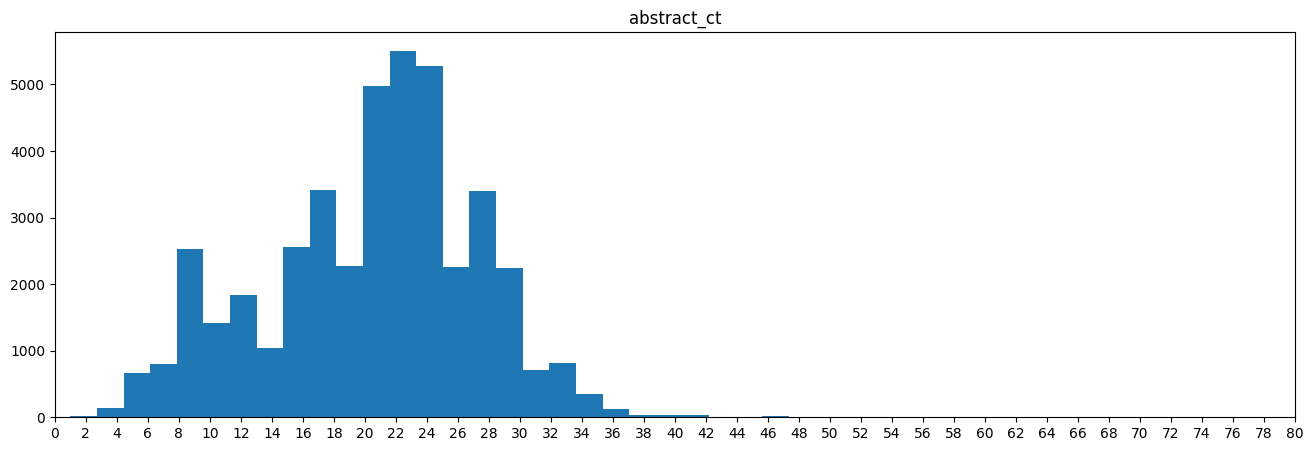

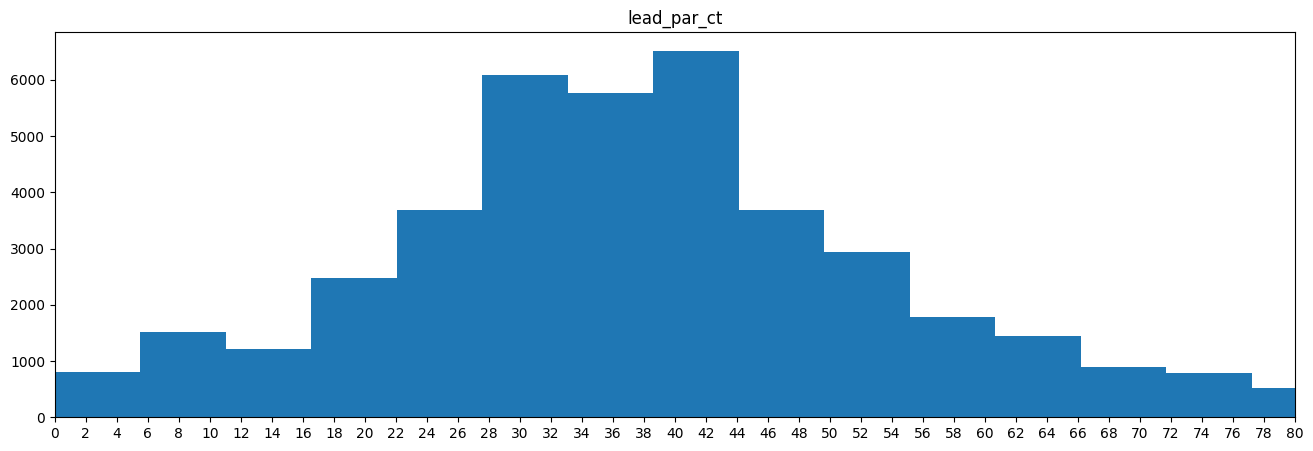

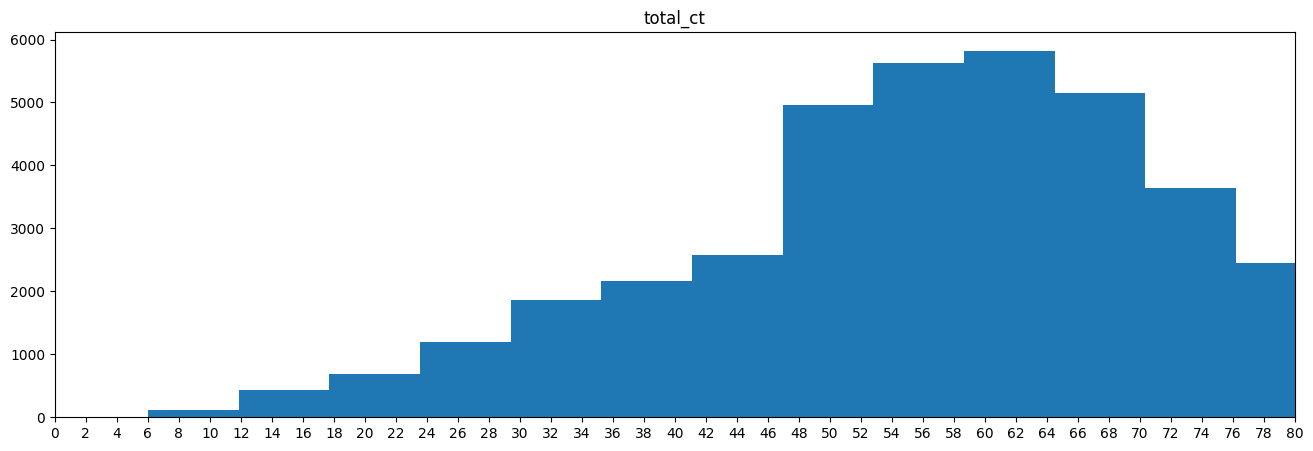

In [26]:
import matplotlib.pyplot as plt

for col in ct_columns:
    plt.figure(figsize=(16,5))
    plt.xlim(xmin=0, xmax=80)
    plt.hist(df[col], bins=60)
    plt.xticks(list(range(0,82,2)))
    plt.title(col)
    plt.show()

Another potential indicator of how much data we have in each entry is the *unique* word count, so let us repeat the same process for that.

In [27]:
df['abstract_uct'] = df.abstract.apply(lambda x: len(set([w for w in x.split(' ') if w != ''])))
df['lead_par_uct'] = df.lead_paragraph.apply(lambda x: len(set([w for w in x.split(' ') if w != ''])))
df['total_uct'] = df.abstract_uct + df.lead_par_uct
uct_columns = ['abstract_uct', 'lead_par_uct', 'total_uct']
df[columns+uct_columns].head(10)

,abstract,lead_paragraph,abstract_uct,lead_par_uct,total_uct
0,economic hardship climate change political instability and gang violence will continue to spur emigration from many corners of the world,relative quiet has prevailed along the southern border since friday despite widespread fears that ending pandemic era policy to immediately expel most migrants even asylum seekers would set off stampede from mexico,20,32,52
1,it election night in america stay away from the bodega sushi,the day before logan roy died he delivered fiery call to arms to his atn staff letting them know what he expected from the network going forward the speech was an angrier variation of the populist spiel he had given many times before in which he insisted that the news should always be frank and unpretentious he wanted his anchors to tell their viewers truthful things they had never heard anyone say before on television he wanted atn to be in word spicy,11,63,74
2,tom is stressed in dress shoes shiv hides beneath layers of lies and turtleneck and willa cosplays as first lady hopeful,this article contains spoilers for episode of the final season of succession,20,11,31
3,no corrections appeared in print on monday may 2023,errors are corrected during the press run whenever possible so some errors noted here may not have appeared in all editions,9,20,29
4,quotation of the day for monday may 2023,for me it was time to give back the love they gave me before,8,13,21
5,the year old french basketball star is the most hyped >nba prospect since lebron james but he says he isn fazed by the pressure,boris diaw was passing through paris in late september and thought he would check out basketball game young player he had heard about for years was playing,21,25,46
6,new york city students are struggling with reading but principals are worried that the rollout of new teaching method is happening too quickly,good morning it monday we ll look at something so fundamental it the first of the three r's and why new york city is about to change the way it is taught in public schools,21,30,51
7,results of turkey election,turkey presidential election appears to be destined for runoff after the incumbent recep tayyip erdogan failed to win majority of the vote in the toughest political challenge of his career,4,26,30
8,shouldn protest movement led by unions be benefiting the left,for three months france has been in revolt demonstrators have marched railroad workers have blocked tracks barricades and buildings have been set aflame protesters have done battle in the street with police the most recent innovation has been tamer people have banged pots whenever the president has appeared the cause president emmanuel macron measure raising the retirement age from to,10,46,56
9,spy drama based on decades long manhunt comes to showtime and new >fx documentary brings back former hillsong pastors to reflect on the church scandal,between network cable and streaming the modern television landscape is vast one here are some of the shows specials and movies coming to tv this week may details and times are subject to change,23,29,52


In [28]:
df[uct_columns].describe()

,abstract_uct,lead_par_uct,total_uct
count,42479.000000,42479.000000,42479.000000
mean,19.096518,35.709103,54.805622
std,6.089161,17.668097,18.639288
min,1.000000,0.000000,6.000000
25%,15.000000,26.000000,44.000000
50%,20.000000,34.000000,54.000000
75%,23.000000,42.000000,64.000000
max,78.000000,218.000000,242.000000


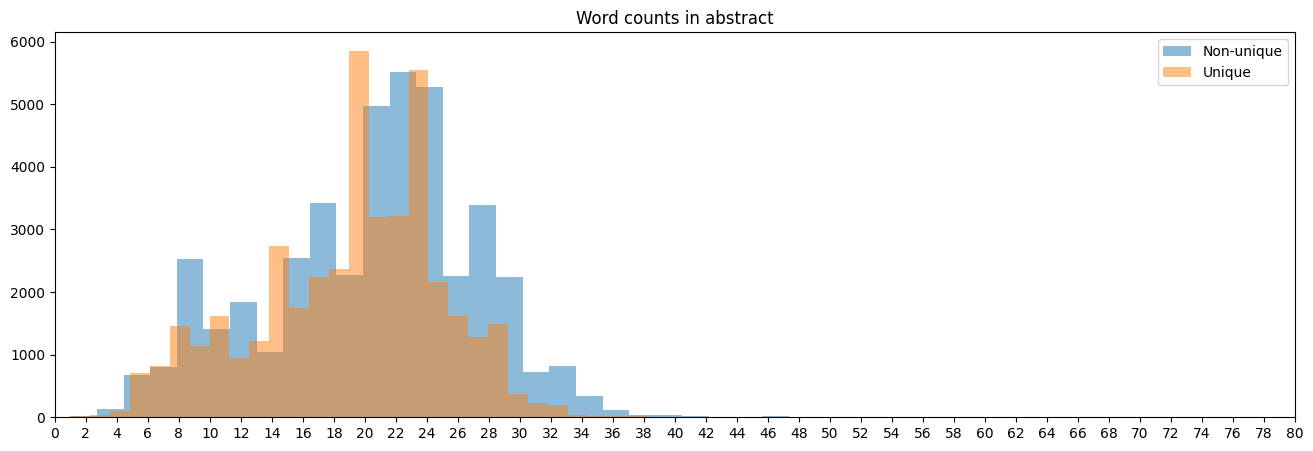

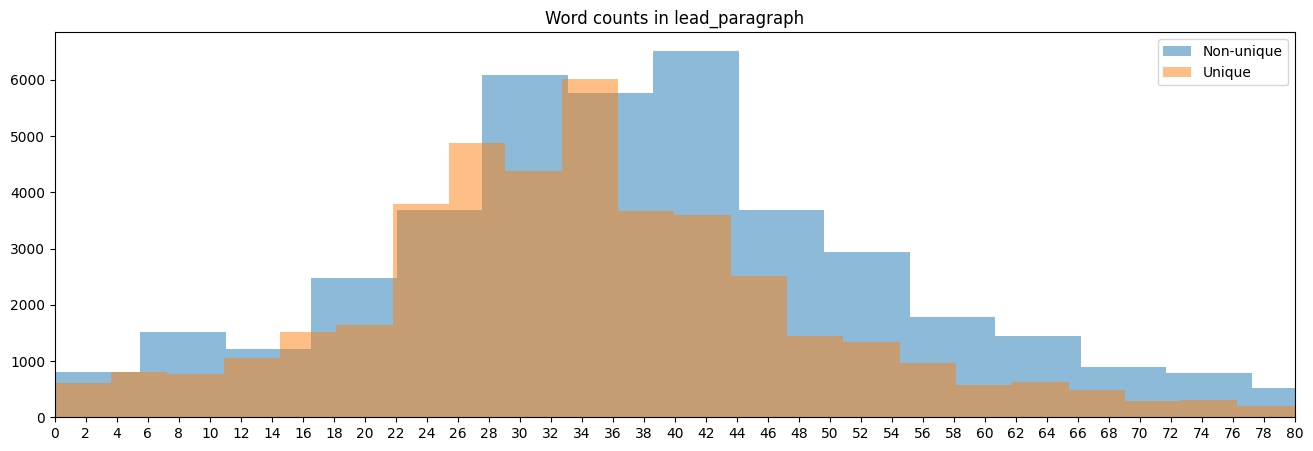

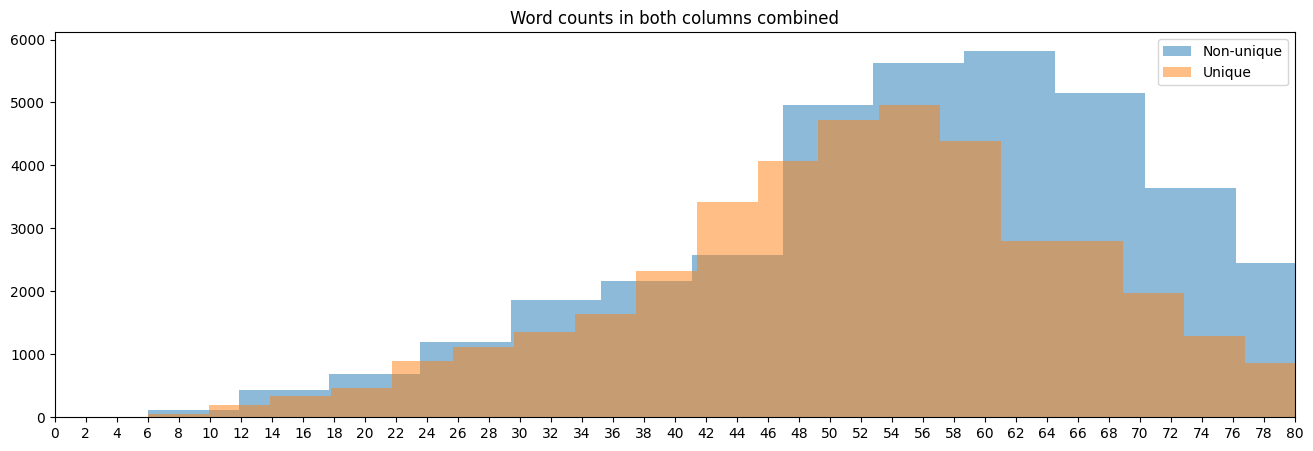

In [29]:
for i in range(3):
    plt.figure(figsize=(16,5))
    plt.xlim(xmin=0, xmax=80)
    plt.hist(df[ct_columns[i]], bins=60, alpha=.5, label='Non-unique')
    plt.hist(df[uct_columns[i]], bins=60, alpha=.5, label='Unique')
    plt.xticks(list(range(0,82,2)))
    plt.title(f"Word counts in {columns[i] if i<2 else 'both columns combined'}")
    plt.legend(loc='upper right')
    plt.show()

There seems to be no relevant difference.

### Garbage articles

Looking through some data points we noticed that many of these are "puzzle hints" or "quotations of the day", both of which we might want to consider removing from the dataset if there are too many of them. Let us count them.

In [30]:
garbage_words = ['puzzle', 'quotation']

for word in garbage_words:
    n = df.abstract.loc[df.abstract.apply(lambda x: word in x)].count()
    print(f'There are a total of {n} abstracts containding the word "{word}", which amounts to {(n*100/df.shape[0]):.2f}% of all abstracts.')

# df.abstract.apply(lambda x: 1 if 'quotation' in x else 0).describe()

There are a total of 1073 abstracts containding the word "puzzle", which amounts to 2.53% of all abstracts.
There are a total of 362 abstracts containding the word "quotation", which amounts to 0.85% of all abstracts.


In [31]:
df.abstract.loc[df.abstract.apply(lambda x: 'puzzle' in x)]

13                            feeling stuck on today puzzle we can help
14       our columnist reviews the day puzzle warning contains spoilers
132                           feeling stuck on today puzzle we can help
133      our columnist reviews the day puzzle warning contains spoilers
274                           feeling stuck on today puzzle we can help
                                      ...                              
42055                         feeling stuck on today puzzle we can help
42213                         feeling stuck on today puzzle we can help
42297                         feeling stuck on today puzzle we can help
42360                         feeling stuck on today puzzle we can help
42487                         feeling stuck on today puzzle we can help
Name: abstract, Length: 1073, dtype: object

In [32]:
df.abstract.loc[df.abstract.apply(lambda x: 'quotation' in x)]

4           quotation of the day for monday may 2023
127        quotation of the day for tuesday may 2023
282      quotation of the day for wednesday may 2023
421       quotation of the day for thursday may 2023
555         quotation of the day for friday may 2023
                            ...                     
42045       quotation of the day for friday may 2024
42207     quotation of the day for saturday may 2024
42283       quotation of the day for sunday may 2024
42413       quotation of the day for monday may 2024
42480      quotation of the day for tuesday may 2024
Name: abstract, Length: 362, dtype: object

Let's drop puzzles and quotations, and plot the histograms from above again to see if there is any significant change.

In [33]:
puzzle_indices_to_drop = list(df.abstract.loc[df.abstract.apply(lambda x: 'puzzle' in x)].index)
quotation_indices_to_drop = list(df.abstract.loc[df.abstract.apply(lambda x: 'quotation' in x)].index)

In [34]:
df = df.drop(puzzle_indices_to_drop + quotation_indices_to_drop)

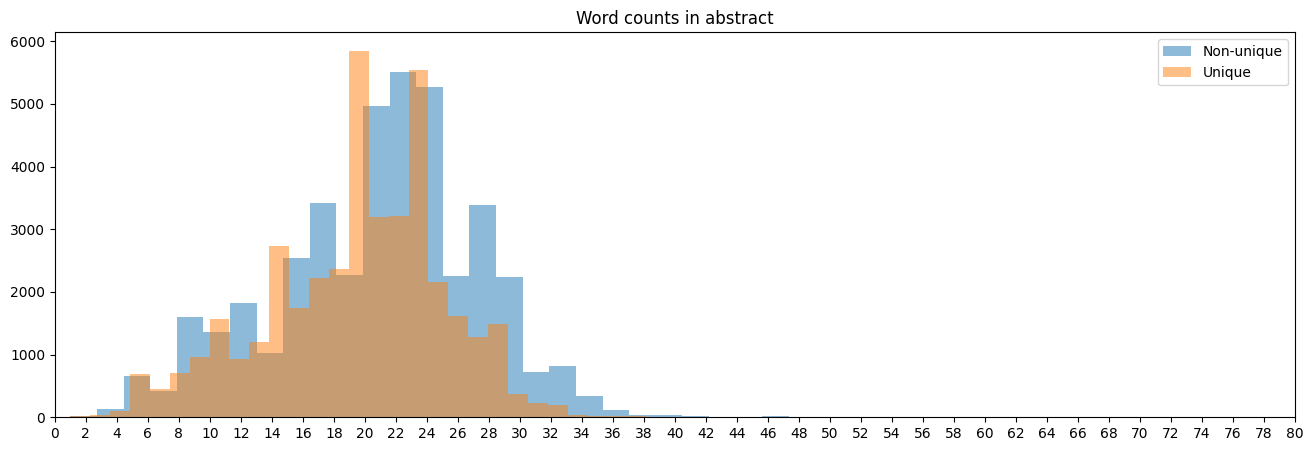

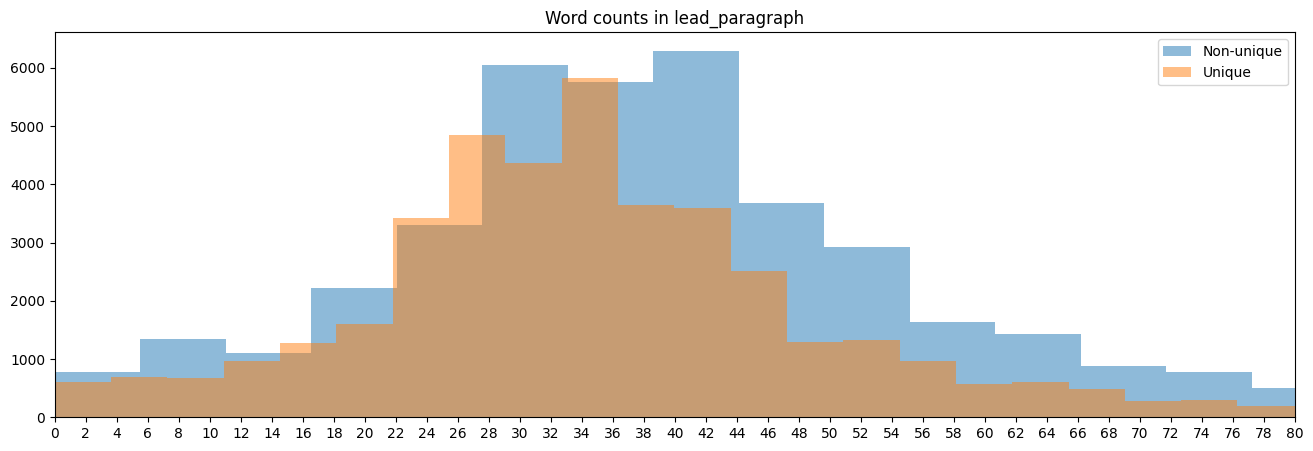

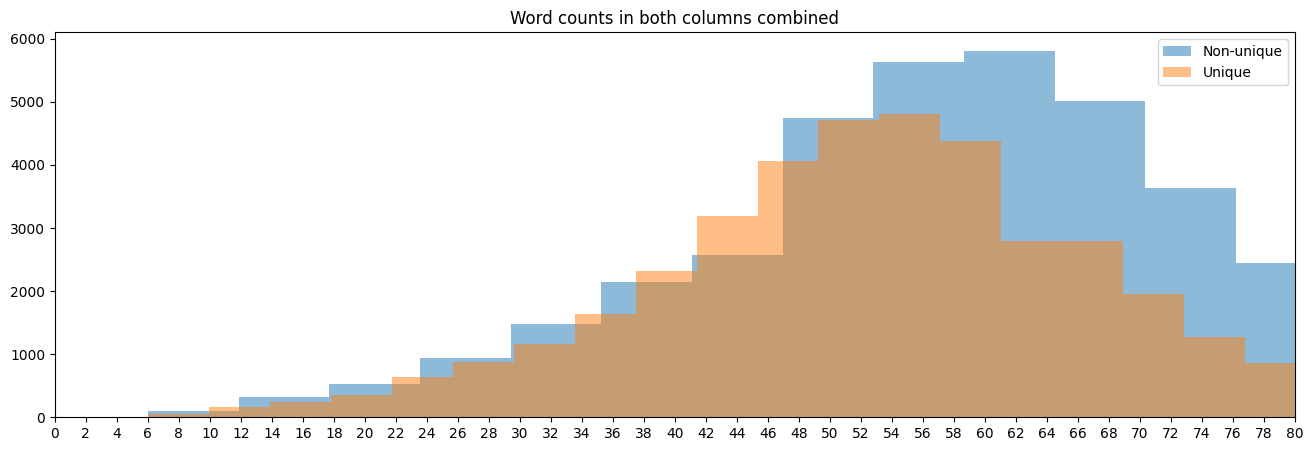

In [35]:
for i in range(3):
    plt.figure(figsize=(16,5))
    plt.xlim(xmin=0, xmax=80)
    plt.hist(df[ct_columns[i]], bins=60, alpha=.5, label='Non-unique')
    plt.hist(df[uct_columns[i]], bins=60, alpha=.5, label='Unique')
    plt.xticks(list(range(0,82,2)))
    plt.title(f"Word counts in {columns[i] if i<2 else 'both columns combined'}")
    plt.legend(loc='upper right')
    plt.show()

There doesn't appear to be a big change so we could either take them out or leave them in. 

## Lemmatization

"Lemmatizing" a corpus means replacing each word with the "base" version—for instance, "being", "is", and "was" would all be replaced by "be", while "mice" would be replaced by "mouse".  
This operation can be perfomed using the `nltk` library, and particularly the `nltk` library and particularly the `WordNetLemmatizer` class.

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize(doc: str, tokenizer=tokenizer) -> list[str]:
    tokens = tokenizer.tokenize(doc)
    return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
df.abstract.apply(lemmatize).head()

> **Note:** This lemmatizer does not seem to be doing great. We tested it on words like "is", "was", "stressed", "went", and "being", with disappointing results.

## Takeaways

We have identified two columns, `'abstract'` and `'lead_paragraph'`, which seem to be of value for our classification problem. The field `'snippet'`, which seemed promising at first glance, later turned out to be either empty or a replica of `'abstract'`, and it was therefore disregarded.  
We have seen that a relatively small portion of articles contain a low number of words, but it might still be a good idea to eliminate them from the corpus to ensure that they can all be identified.

### Potential hyperparameters

The following filters may potentially be tuned to decide exactly how to form our corpus.
- Filter out all articles with fewer than a set word count;
- Exclude "Puzzle hint" and "Quotation of the day" articles.